# Advanced Monte Carlo Methods for Bayesian Inference

This notebook containes all the Python code used in Chapter 5: Advanced Monte Carlo Methods for Bayesian Inference. Below, we shall explore how to implement MCMC and SMC algorithms to perform Bayesian Inference, we will focus on how to estimate model parameters and hidden state values.

**Index:**
* [Markov Chain Monte Carlo](#markov-chain-monte-carlo)
* [Sequential Monte Carlo](#sequential-monte-carlo)

In [186]:
#Import all libraries
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

## Markov Chain Monte Carlo

Let us assume we are interested in estimating the bias of a coin, represented by the probability $\theta$ that the coin will land on heads. Initially, we assumed that the coin was unbiased ($\theta = 0.5$). However, after launching the coin $20$ times, $15$ tosses resulted in heads. Taking into account our prior belief and the data, what will be the posterior probability distribution for the bias of the coin?

If we consider each individual coin flip independently, we can model the probability that the coin lands in heads through a Bernoulli distribution with parameter $\theta$. In addition, if we assign $\theta$ the $\beta(10,10)$ prior distribution, all that is left is to compute the posterior distribution for the coin's bias.

$$
p(\theta | x_{1:20}) = \frac{p(x_{1:20}| \theta) p(\theta)}{\int p(x_{1:20} | \theta) p(\theta) d\theta }
$$


By definition, we know that
\begin{align*}
p(\theta) & = \frac{1}{\beta(10,10)} \theta^{10-1}(1-\theta)^{10-1} \\
 & = \frac{1}{\beta(10,10)} \theta^{9}(1-\theta)^{9}
\end{align*}
and
\begin{align*}
p(x_{1:20}| \theta) & = \prod_{i=1}^{20} \theta^{x_i}(1-\theta)^{1-x_i} \\
 & = \theta^{15}(1-\theta)^5
\end{align*}
where $x_i = 1$ when the coin lands in heads and $x_i = 0$ when it lands in tails. 

Substituting back into our posterior, and using $p(\theta | x_{1:20}) \propto p(x_{1:20}| \theta) p(\theta)$ it results that
\begin{align*}
p(\theta | x_{1:20}) \propto \frac{1}{\beta(10)(10)} \theta^{24}(1-\theta)^{14}.
\end{align*}
Fortunately, we can analytically obtain our marginal likelihood through
\begin{align*}
\int_0^1 p(x_{1:20} | \theta) p(\theta) d\theta &= \int_0^1  \frac{1}{\beta(10)(10)} \theta^{24}(1-\theta)^{14} d\theta \\
 &= \frac{\beta(25,15)}{\beta(10)(10)} \int_0^1 \frac{1}{\beta(25,15)}\theta^{24}(1-\theta)^{14} d\theta \\
 &= \frac{\beta(25,15)}{\beta(10)(10)}
\end{align*}

With this in mind, we can conclude that $\theta | X \sim \beta(25,15)$ and the posterior mean is given by
$$
\mathbb{E}[\theta | X] = \frac{\alpha}{\alpha + \beta} = \frac{25}{40} = 0.625. 
$$
In this example, the prior and likelihood distributions were carefully chosen to be conjugate, allowing the posterior distribution to have a closed analytical form. In practice, this is rare, and it is necessary to rely on MCMC techniques to approximate the posterior numerically. We can now rely on the Metropolis-Hastings algorithm to validate that we get a consistent result.

In [35]:
# Lets create a np.array with our observed data x_i
num_tosses = 20
num_heads = 15

data = np.array([1] * num_heads + [0] * (num_tosses - num_heads))
np.random.shuffle(data)

# We can define the prior and likelihood distributions
def prior(x):
    alpha = 10
    beta =10 
    return stats.beta(alpha,beta).pdf(x)

def likelihood(theta, data):
    trials = len(data)
    heads = data.sum()
    return theta**heads * (1-theta)**(trials - heads)

# Apply MH MCMC to estimate the posterior distribution
num_chains = 4 
num_iterations = 8000
burnin = 2000
chain_length = num_iterations + burnin

theta = np.zeros(num_iterations+burnin)
theta[0] = stats.beta(10,10).rvs(1)[0]

chains = np.zeros((num_chains, chain_length))

for chain_index in range(num_chains):
    chains[chain_index][0] = stats.uniform(0,1).rvs()
    
    # Generate chain samples
    for t in range(1, chain_length):
        theta_new = stats.norm(chains[chain_index][t-1], 0.05).rvs()
        prior_ratio = prior(theta_new) / prior(chains[chain_index][t-1])
        like_ratio = likelihood(theta_new, data) / likelihood(chains[chain_index][t-1], data)
        acceptance_ratio = min(1, prior_ratio * like_ratio)

        u = stats.uniform(0, 1).rvs()
        if u <= acceptance_ratio:
            chains[chain_index][t] = theta_new
        else:
            chains[chain_index][t] = chains[chain_index][t-1]

In [ ]:
# Plot prior vs posterior distributions

prior_values = stats.beta(10,10).rvs(1000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.hist(prior_values, bins = 15)


plt.axvline(x=np.mean(prior_values), color='green', linestyle='--', label='Prior mean')
plt.xlabel('Theta')
plt.legend()
plt.show()

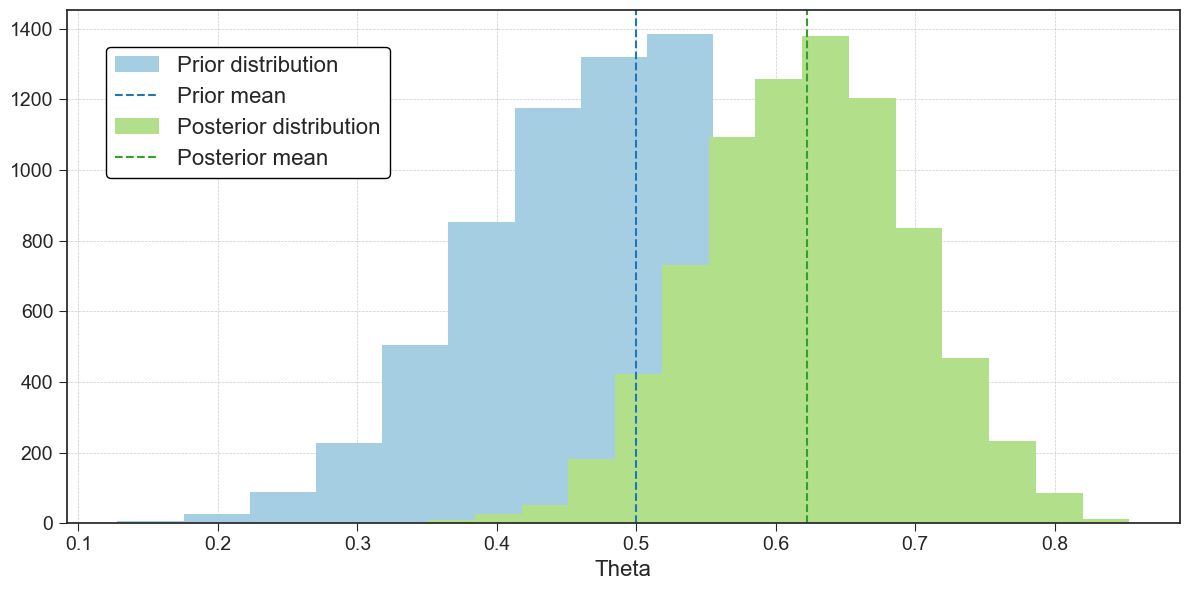

Posterior mean: 0.622


In [230]:
# Show the plot for the prior and posterior distributions
prior_values = stats.beta(10,10).rvs(8000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.hist(prior_values, bins = 15, color = colors[0], label='Prior distribution')
plt.axvline(x=np.mean(prior_values), color=colors[1], linestyle='--', label='Prior mean')

plt.hist(chains[0,burnin:], bins = 15, color = colors[2], label='Posterior distribution')
plt.axvline(x=np.mean(chains[0,burnin:]), color=colors[3], linestyle='--', label='Posterior mean')

plt.xlabel('Theta', fontsize=16)

plt.legend(
    bbox_to_anchor=(0.3, 0.95),
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

print('Posterior mean: {:.3f}'.format(np.mean(chains[0, burnin:])))

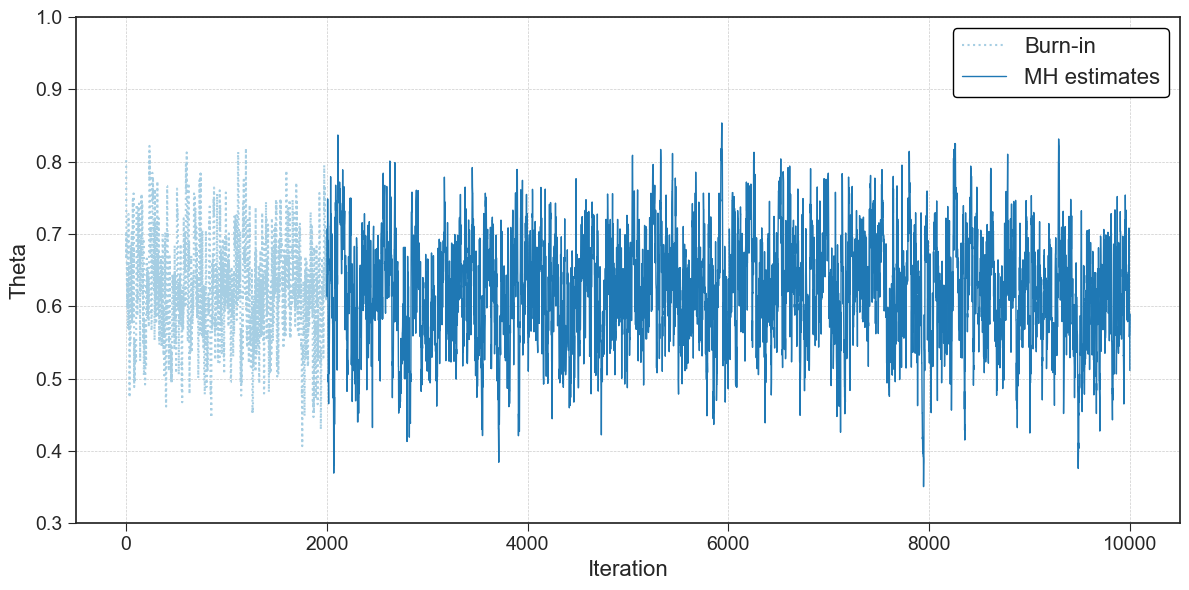

In [212]:
# Show trace plot for the first chain
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

# Plot the burn-in period in a different color
plt.plot(np.arange(burnin), chains[0,: burnin], color=colors[0], label='Burn-in', linewidth=1.5, linestyle=':')

# Plot the remaining iterations after burn-in in blue
plt.plot(np.arange(burnin, num_iterations + burnin), chains[0,burnin:], color=colors[1], label='MH estimates', linewidth=1)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Theta', fontsize=16)
plt.ylim(0.3,1)
plt.legend(
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

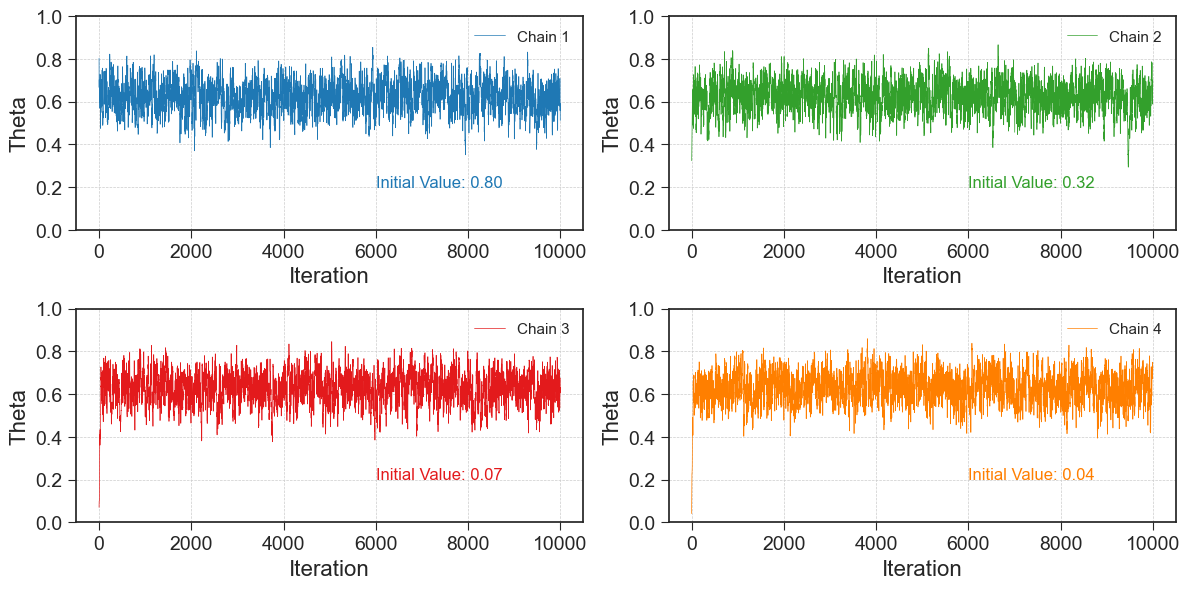

In [174]:
# Compare trace plots of each chain
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')
color_map = {0: 1, 1: 3, 2: 5, 3: 7}

for chain_index in range(num_chains):
    plt.subplot(2, 2, chain_index+1)
    plt.plot(chains[chain_index], label=f'Chain {chain_index+1}', color=colors[color_map[chain_index]], linewidth=0.5)
    plt.text(6000, 0.2, f'Initial Value: {chains[chain_index][0]:.2f}', color=colors[color_map[chain_index]], fontsize=12)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)  
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Theta',fontsize=16)
    plt.ylim(0, 1)
    plt.legend(fontsize=11)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    
plt.show()

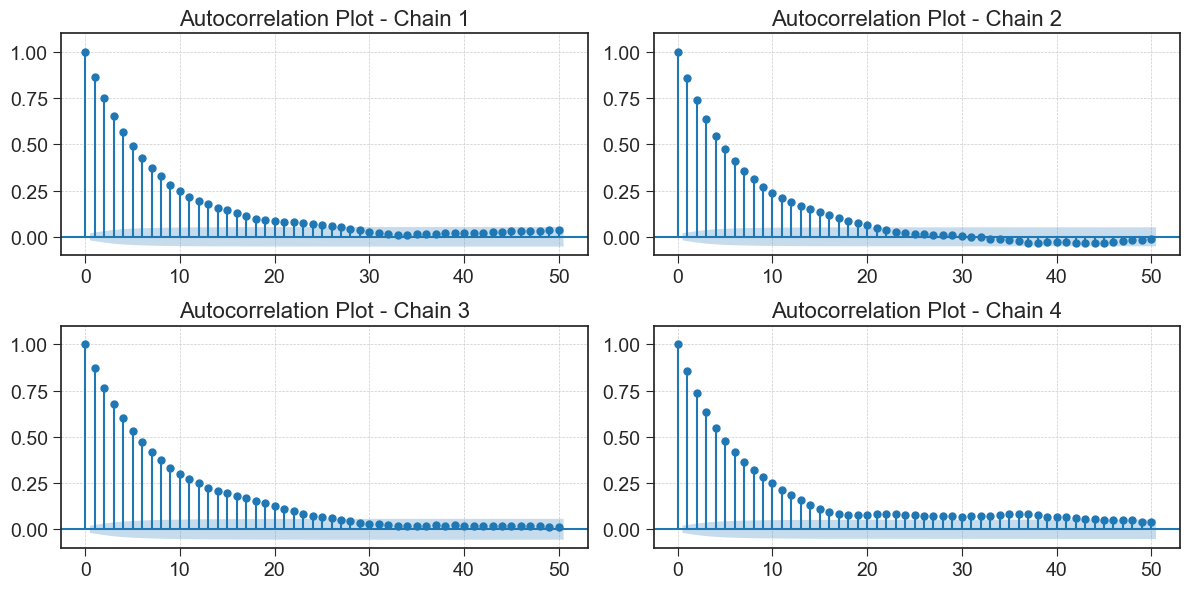

In [185]:
# Compute autocorrelation plots for each chain 

fig, axs = plt.subplots(2, 2, figsize=(12,6))  
axs = axs.flatten() 

for chain_index in range(num_chains):
    ax = axs[chain_index]
    sm.graphics.tsa.plot_acf(chains[chain_index], lags=50, ax=ax) 
    ax.set_title(f'Autocorrelation Plot - Chain {chain_index + 1}', fontsize=16)
    ax.set_ylim(-0.1, 1.1) 
    ax.grid(visible=True, linestyle='--', linewidth=0.5)  
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

plt.show()


In [160]:
def gelman_rubin(chains, burnin):
    K, L = chains.shape
    chains_L = chains[:, burnin:]
    
    chain_means = np.mean(chains_L, axis=1)
    overall_mean = np.mean(chain_means)
    
    # Between-chain variance
    B = (L / (L - 1)) * np.sum((chain_means - overall_mean) ** 2)
    
    # Within-chain variance
    W = (1 / K) * np.sum(np.var(chains, axis=1, ddof=1))
    
    # Estimate of marginal posterior variance
    V_hat = (L-1)/(L) * W + (B / L)
    
    # Potential Scale Reduction Factor
    R_hat = np.sqrt(V_hat / W)
    
    return R_hat

In [193]:
R_hat = gelman_rubin(chains, burnin)
print(f"Gelman-Rubin statistic (R-hat): {R_hat}")

Gelman-Rubin statistic (R-hat): 0.9999503826612758


## Sequential Monte Carlo

In this section we explore the different examples for the SMC algorythms defined in Chapter 4

### Sequential Importance Sampling Algorithm

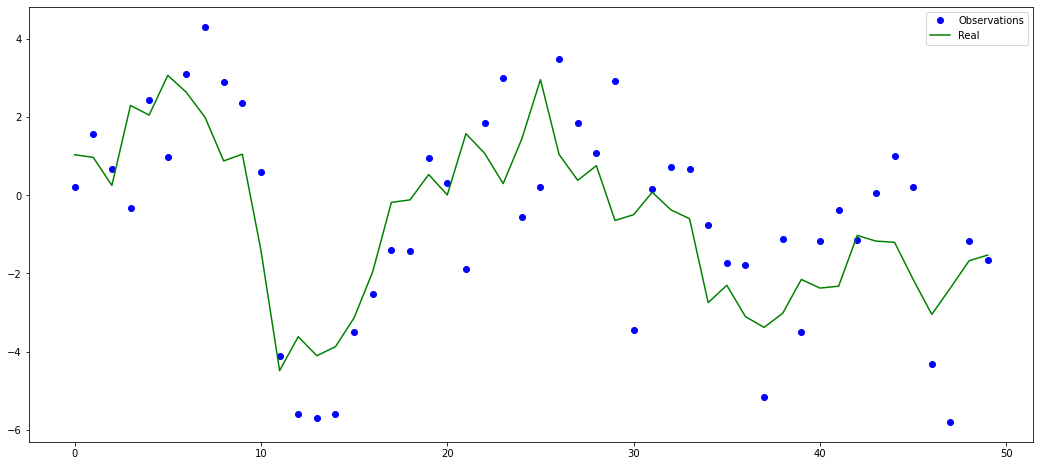

In [14]:
# Define parameters
num_particles = 1000
alpha = 0.95
sigma_v = 1.0
sigma_w = 1.5

T = 50 # Define the number of time steps
time = np.arange(T) # Create a time vector 

# True object motion model
def f(x):
    return alpha*x + np.random.normal(0, sigma_v)

# Observation model
def g(x):
    return x + np.random.normal(0, sigma_w)

# Observations
X_real = np.zeros(T)
Y_obs = np.zeros(T)
X_real[0] = np.random.normal(0, sigma_v)
Y_obs[0] = g(X_real[0])
for t in range(1, T):
    X_real[t] = f(X_real[t-1])
    Y_obs[t] = g(X_real[t-1])
    
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.legend()
plt.show()

In [ ]:
def sample_trajectory(ancestry_matrix, particles_matrix):
    num_time_steps = ancestry_matrix.shape[1]
    num_particles = ancestry_matrix.shape[0]
    trajectory = np.zeros(num_time_steps)  # Initialize the trajectory array
    
    # Sample the particle index from the last time step
    sampled_index = np.random.choice(np.arange(num_particles)).astype(int)
    trajectory[-1] = particles_matrix[sampled_index, -1]
    
    # Recursively sample particles from previous time steps
    for t in range(num_time_steps - 2, -1, -1):  # Iterate backward in time
        # Get the ancestor index at the previous time step
        sampled_index = ancestry_matrix[sampled_index, t].astype(int)
        # Update the trajectory array with the state from the particles matrix
        trajectory[t] = particles_matrix[sampled_index, t]
    
    return trajectory

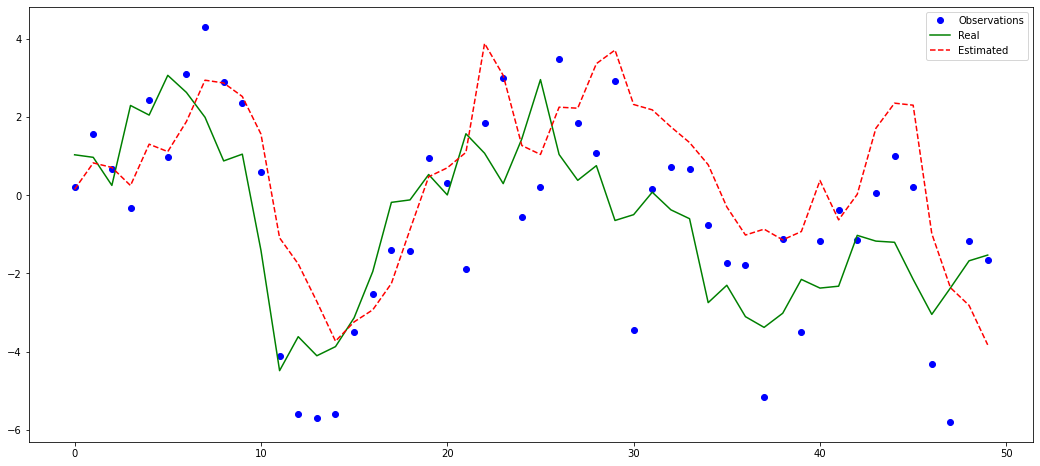

In [17]:
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states
estimated_states = []

# Time t=1
particles[:,0] = stats.norm(0,2).rvs(size=num_particles)
weights[:,0] = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[0] - particles[:, 0])**2 / (2 * sigma_w**2))
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()

ESS[0] = 1 / (norm_weights[:,0]**2).sum()

estimated_states.append(np.sum(particles[:, 0]*norm_weights[:,0]))

# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = alpha*particles[:, t - 1] + stats.norm(0,sigma_v).rvs(num_particles)

    # Update step: compute importance weights based on observation model
    incremental_weight = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[t] - particles[:, t])**2 / (2 * sigma_w**2))
    weights[:, t] = weights[:,t-1]*incremental_weight  
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    
    ESS[t]= 1 / np.sum(norm_weights**2)

    # Compute estimated state (weighted mean of particles)
    estimated_states.append(np.sum(particles[:, t] * norm_weights[:, t]))
    
# Plot results
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.plot(time, estimated_states, 'r--', label='Estimated')
plt.legend()
plt.show()

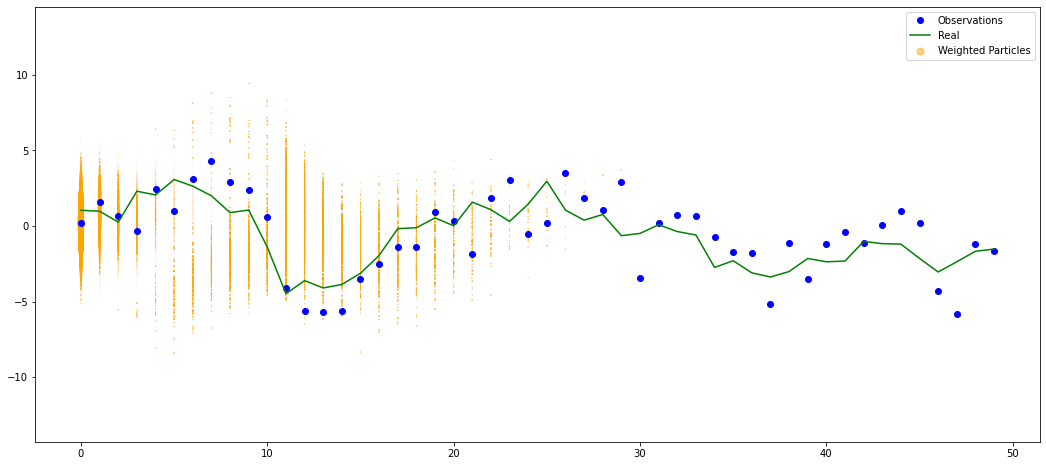

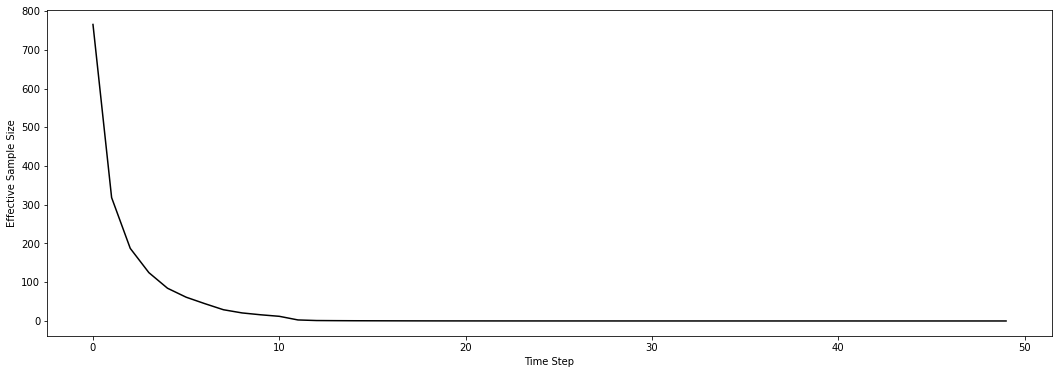

In [19]:
# Plot results
plt.figure(figsize=(18, 8))
# Plot observations
plt.plot(time, Y_obs, 'b o', label='Observations')

# Plot real state
plt.plot(time, X_real, 'g', label='Real')

# Plot weighted particles
for t in range(T):
    sizes = 100 * weights[:, t]  # Use weights to determine marker size (scaled for better visibility)
    plt.scatter([time[t]] * num_particles, particles[:, t], s=sizes, c='orange', alpha=0.5)

plt.scatter([], [], s=50, c='orange', alpha=0.5, label='Weighted Particles')
plt.legend()
plt.show()

# Plot ESS in a separate chart
plt.figure(figsize=(18, 6))
plt.plot(time, ESS, color='black')
plt.xlabel('Time Step')
plt.ylabel('Effective Sample Size')
plt.show()


### Botstrap Particle Filter

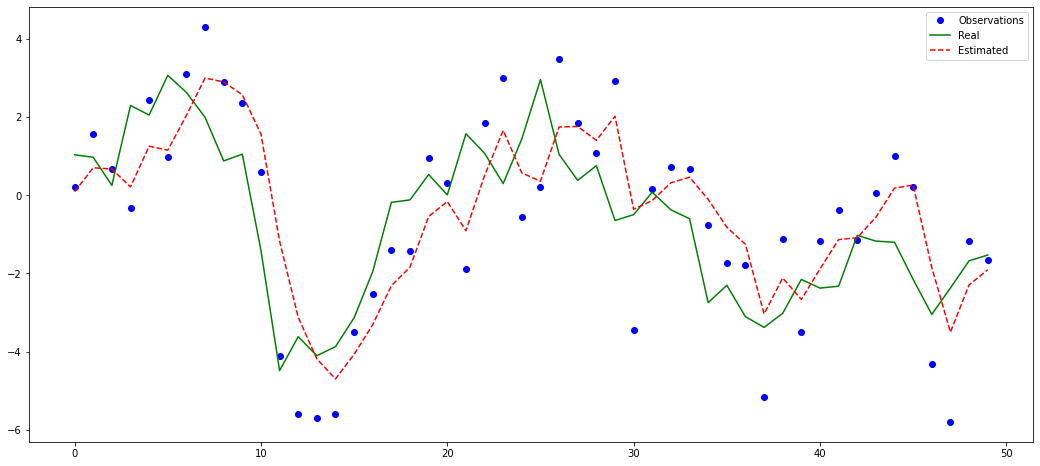

In [22]:
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states
estimated_states = []

# Time t=1
particles[:,0] = stats.norm(0,1).rvs(size=num_particles)
weights[:,0] = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[0] - particles[:, 0])**2 / (2 * sigma_w**2))
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()

ESS[0] = 1 / (norm_weights[:,0]**2).sum()
if ESS[0] < num_particles*0.5:
    # Update particles and weights based on resampled indices
    resampled_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:, 0])
    particles[:, 0] = particles[resampled_indices, 0]
    weights[:, 0] = 1 / num_particles  # Reset weights to uniform distribution after resampling
    norm_weights[:, 0] = weights[:,0]
    # Compute estimated state (weighted mean of particles)
    estimated_states.append(np.sum(particles[:, 0] * norm_weights[:, 0]))
else:
    estimated_states.append(np.sum(particles[:, 0] * norm_weights[:, 0]))
    
# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = alpha*particles[:, t - 1] + stats.norm(0,sigma_v).rvs(num_particles)

    # Update step: compute importance weights based on observation model
    incremental_weight = 1 / np.sqrt(2 * np.pi * sigma_w**2) * np.exp(-(Y_obs[t] - particles[:, t])**2 / (2 * sigma_w**2))
    weights[:, t] = weights[:,t-1]*incremental_weight  
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    
    ESS[t]= 1 / np.sum(norm_weights**2)
    if ESS[t] < num_particles*0.5:
        # Update particles and weights based on resampled indices
        resampled_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:, t])
        particles[:, t] = particles[resampled_indices, t]
        weights[:, t] = 1 / num_particles  # Reset weights to uniform distribution after resampling
        norm_weights[:, t] = weights[:,t]
        # Compute estimated state (weighted mean of particles)
        estimated_states.append(np.sum(particles[:, t] * norm_weights[:, t]))
    else:
        estimated_states.append(np.sum(particles[:, t] * norm_weights[:, t]))
    
# Plot results
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.plot(time, estimated_states, 'r--', label='Estimated')
plt.legend()
plt.show()

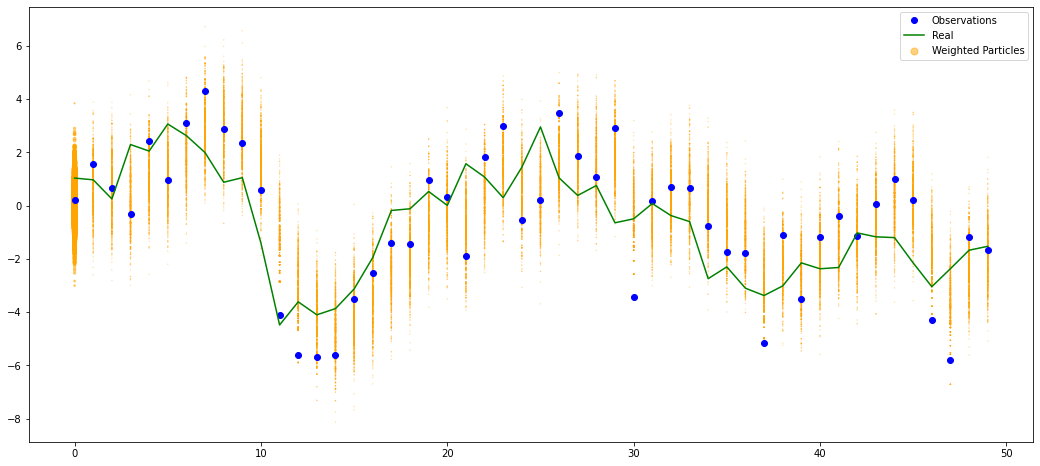

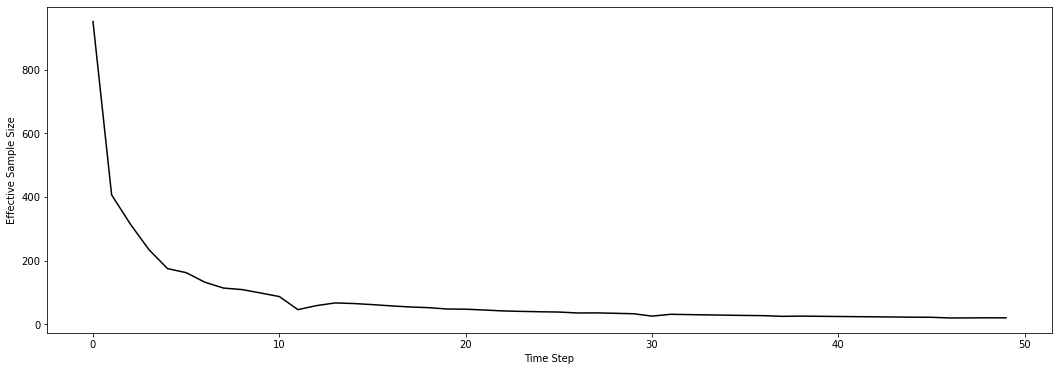

In [23]:
# Plot results
plt.figure(figsize=(18, 8))
# Plot observations
plt.plot(time, Y_obs, 'b o', label='Observations')

# Plot real state
plt.plot(time, X_real, 'g', label='Real')

# Plot weighted particles
for t in range(T):
    sizes = 100 * weights[:, t]  # Use weights to determine marker size (scaled for better visibility)
    plt.scatter([time[t]] * num_particles, particles[:, t], s=sizes, c='orange', alpha=0.5)

plt.scatter([], [], s=50, c='orange', alpha=0.5, label='Weighted Particles')
plt.legend()
plt.show()

# Plot ESS in a separate chart
plt.figure(figsize=(18, 6))
plt.plot(time, ESS, color='black')
plt.xlabel('Time Step')
plt.ylabel('Effective Sample Size')
plt.show()


## MCMC Example

Lets assume we are interested in estimating the bias of a coin.

In [8]:
num_tosses = 20
num_heads = 15

data = np.array([1] * num_heads + [0] * (num_tosses - num_heads))
np.random.shuffle(data)

def prior(x):
    a=b=1 #non informative prior
    return stats.beta(a,b).pdf(x)

def likelihood(theta, data):
    trials = len(data)
    heads = data.sum()
    return theta**heads * (1-theta)**(trials - heads)

num_iterations = 8000
burnin = 2000
#initialize chain
theta = np.zeros(num_iterations+burnin)
theta[0] = 0.5

for t in range(1,num_iterations+burnin):
    theta_new = stats.norm(theta[t-1],0.05).rvs()
    prior_ratio = prior(theta_new) / prior(theta[t-1])
    like_ratio = likelihood(theta_new, data) / likelihood(theta[t-1], data)
    acceptance_ratio = min(1,prior_ratio*like_ratio)
    
    u = stats.uniform(0,1).rvs()
    if u <= acceptance_ratio:
        theta[t] = theta_new
    else:
        theta[t] = theta[t-1]

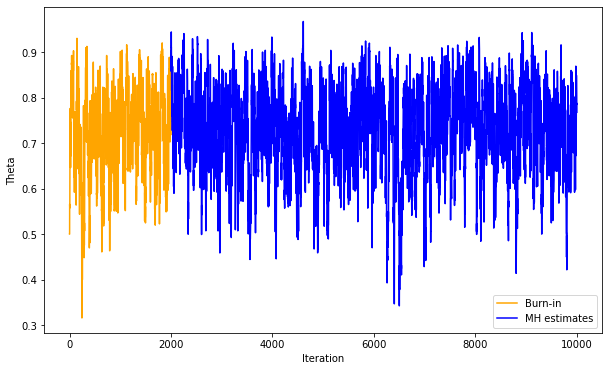

In [9]:
plt.figure(figsize=(10, 6))

# Plot the burn-in period in a different color
plt.plot(np.arange(burnin), theta[:burnin], color='orange', label='Burn-in')

# Plot the remaining iterations after burn-in in blue
plt.plot(np.arange(burnin, num_iterations + burnin), theta[burnin:], color='blue', label='MH estimates')

plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.legend()
plt.show()

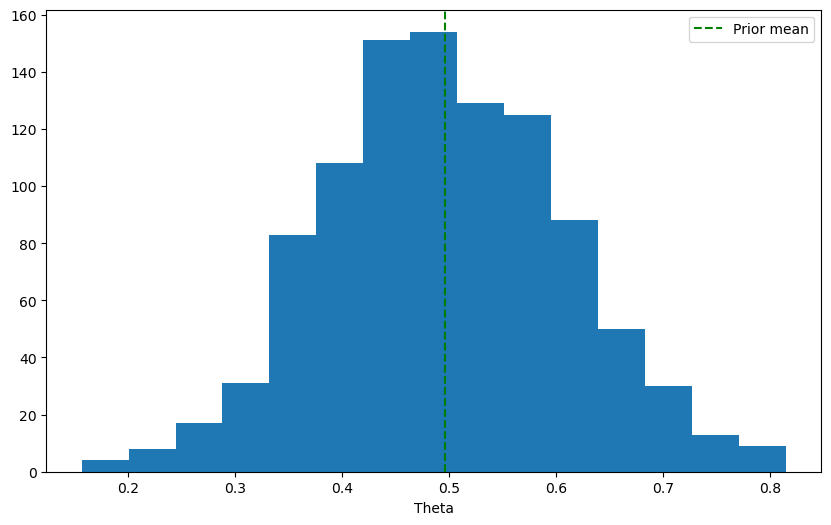

In [16]:
# Generate a range of values for theta
prior_values = stats.beta(10,10).rvs(1000)
# Plot the prior distribution
plt.figure(figsize=(10, 6))
plt.hist(prior_values, bins = 15)
plt.axvline(x=np.mean(prior_values), color='green', linestyle='--', label='Prior mean')
plt.xlabel('Theta')
plt.legend()
plt.show()

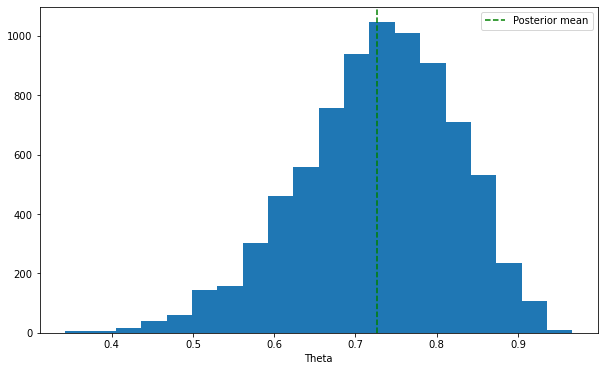

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(theta[burnin:], bins = 20)
plt.axvline(x=np.mean(theta[burnin:]), color='green', linestyle='--', label='Posterior mean')
plt.xlabel('Theta')
plt.legend()
plt.show()